# Food Delivery Data Analysis Project

## Objective
This project combines transactional, user, and restaurant datasets
to analyze revenue trends, user behavior, city-wise performance,
membership impact, and restaurant insights.

The final merged dataset is used as the single source of truth
for all analytical questions in this hackathon.


In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# Verify files in /content
import os
os.listdir("/content")


['.config', 'orders.csv', 'users.json', 'restaurants.sql', 'sample_data']

In [2]:
orders = pd.read_csv("/content/orders.csv")
orders.head()


,order_id,user_id,restaurant_id,order_date,total_amount,restaurant_name
0,1,2508,450,18-02-2023,842.97,New Foods Chinese
1,2,2693,309,18-01-2023,546.68,Ruchi Curry House Multicuisine
2,3,2084,107,15-07-2023,163.93,Spice Kitchen Punjabi
3,4,319,224,04-10-2023,1155.97,Darbar Kitchen Non-Veg
4,5,1064,293,25-12-2023,1321.91,Royal Eatery South Indian


In [3]:
users = pd.read_json("/content/users.json")
users.head()


,user_id,name,city,membership
0,1,User_1,Chennai,Regular
1,2,User_2,Pune,Gold
2,3,User_3,Bangalore,Gold
3,4,User_4,Bangalore,Regular
4,5,User_5,Pune,Gold


In [4]:
conn = sqlite3.connect(":memory:")

with open("/content/restaurants.sql", "r") as f:
    sql_script = f.read()

conn.executescript(sql_script)

restaurants = pd.read_sql("SELECT * FROM restaurants", conn)
restaurants.head()


,restaurant_id,restaurant_name,cuisine,rating
0,1,Restaurant_1,Chinese,4.8
1,2,Restaurant_2,Indian,4.1
2,3,Restaurant_3,Mexican,4.3
3,4,Restaurant_4,Chinese,4.1
4,5,Restaurant_5,Chinese,4.8


## Data Merging

We merge the datasets using LEFT JOINs to ensure that all order records
are retained even if corresponding user or restaurant details are missing.

Join keys used:
- orders.user_id → users.user_id
- orders.restaurant_id → restaurants.restaurant_id


In [5]:
final_df = (
    orders
    .merge(users, on="user_id", how="left")
    .merge(restaurants, on="restaurant_id", how="left")
)

final_df.head()


,order_id,user_id,restaurant_id,order_date,total_amount,restaurant_name_x,name,city,membership,restaurant_name_y,cuisine,rating
0,1,2508,450,18-02-2023,842.97,New Foods Chinese,User_2508,Hyderabad,Regular,Restaurant_450,Mexican,3.2
1,2,2693,309,18-01-2023,546.68,Ruchi Curry House Multicuisine,User_2693,Pune,Regular,Restaurant_309,Indian,4.5
2,3,2084,107,15-07-2023,163.93,Spice Kitchen Punjabi,User_2084,Chennai,Gold,Restaurant_107,Mexican,4.0
3,4,319,224,04-10-2023,1155.97,Darbar Kitchen Non-Veg,User_319,Bangalore,Gold,Restaurant_224,Chinese,4.8
4,5,1064,293,25-12-2023,1321.91,Royal Eatery South Indian,User_1064,Pune,Regular,Restaurant_293,Italian,3.0


In [6]:
final_df = (
    orders
    .merge(users, on="user_id", how="left")
    .merge(restaurants, on="restaurant_id", how="left")
)

final_df.head()


,order_id,user_id,restaurant_id,order_date,total_amount,restaurant_name_x,name,city,membership,restaurant_name_y,cuisine,rating
0,1,2508,450,18-02-2023,842.97,New Foods Chinese,User_2508,Hyderabad,Regular,Restaurant_450,Mexican,3.2
1,2,2693,309,18-01-2023,546.68,Ruchi Curry House Multicuisine,User_2693,Pune,Regular,Restaurant_309,Indian,4.5
2,3,2084,107,15-07-2023,163.93,Spice Kitchen Punjabi,User_2084,Chennai,Gold,Restaurant_107,Mexican,4.0
3,4,319,224,04-10-2023,1155.97,Darbar Kitchen Non-Veg,User_319,Bangalore,Gold,Restaurant_224,Chinese,4.8
4,5,1064,293,25-12-2023,1321.91,Royal Eatery South Indian,User_1064,Pune,Regular,Restaurant_293,Italian,3.0


In [7]:
final_df.shape


(10000, 12)

## Orders by Membership Type
This section analyzes how many orders were placed by Gold and Regular members.


In [8]:
final_df["membership"].value_counts()


,count
membership,
Regular,5013
Gold,4987


## Revenue by City
This section shows total revenue generated from each city.


In [9]:
final_df.groupby("city")["total_amount"].sum().sort_values(ascending=False)


,total_amount
city,
Bangalore,2206946.58
Chennai,1990513.03
Pune,1924797.93
Hyderabad,1889366.58


## Average Order Value (Gold Members)


In [10]:
final_df[final_df["membership"] == "Gold"]["total_amount"].mean()


np.float64(797.1455564467616)

## Orders from High Rated Restaurants (Rating ≥ 4.5)


In [11]:
final_df[final_df["rating"] >= 4.5].shape[0]


3374

## Revenue Distribution by City

The bar chart below visualizes total revenue generated from each city,
helping identify top-performing locations.


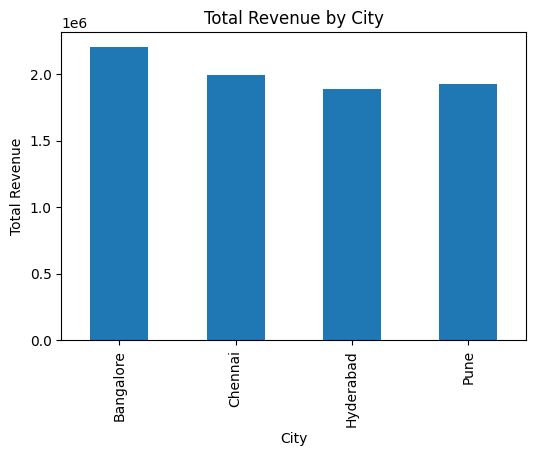

In [12]:
final_df.groupby("city")["total_amount"].sum().plot(
    kind="bar",
    title="Total Revenue by City",
    ylabel="Total Revenue",
    xlabel="City",
    figsize=(6,4)
)

plt.show()


In [13]:
final_df.to_csv("final_food_delivery_dataset.csv", index=False)


### 1. City with Highest Total Revenue from Gold Members


In [14]:
(
    final_df[final_df["membership"] == "Gold"]
    .groupby("city")["total_amount"]
    .sum()
    .sort_values(ascending=False)
)


,total_amount
city,
Chennai,1080909.79
Pune,1003012.32
Bangalore,994702.59
Hyderabad,896740.19


### 2. Cuisine with Highest Average Order Value


In [15]:
final_df.groupby("cuisine")["total_amount"].mean().sort_values(ascending=False)


,total_amount
cuisine,
Mexican,808.021344
Italian,799.448578
Indian,798.466011
Chinese,798.389020


How many distinct users placed orders worth more than ₹1000 in total (sum of all their orders)?

In [17]:
user_spend = (
    final_df
    .groupby("user_id")["total_amount"]
    .sum()
)

user_spend[user_spend > 1000].count()


np.int64(2544)

Which restaurant rating range generated the highest total revenue?

In [18]:
# Create rating buckets
final_df["rating_range"] = pd.cut(
    final_df["rating"],
    bins=[3.0, 3.5, 4.0, 4.5, 5.0],
    labels=["3.0–3.5", "3.6–4.0", "4.1–4.5", "4.6–5.0"]
)

(
    final_df
    .groupby("rating_range")["total_amount"]
    .sum()
    .sort_values(ascending=False)
)


/tmp/ipython-input-4139473961.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("rating_range")["total_amount"]


,total_amount
rating_range,
4.6–5.0,2197030.75
4.1–4.5,1960326.26
3.0–3.5,1881754.57
3.6–4.0,1717494.41


Among Gold members, which city has the highest average order value?

In [19]:
(
    final_df[final_df["membership"] == "Gold"]
    .groupby("city")["total_amount"]
    .mean()
    .sort_values(ascending=False)
)


,total_amount
city,
Chennai,808.459080
Hyderabad,806.421034
Bangalore,793.223756
Pune,781.162243


Which cuisine has the lowest number of distinct restaurants but still significant revenue?

In [20]:
restaurant_count = (
    final_df
    .groupby("cuisine")["restaurant_id"]
    .nunique()
)

revenue_by_cuisine = (
    final_df
    .groupby("cuisine")["total_amount"]
    .sum()
)

pd.concat(
    [restaurant_count, revenue_by_cuisine],
    axis=1,
    keys=["restaurant_count", "total_revenue"]
).sort_values("restaurant_count")


,restaurant_count,total_revenue
cuisine,,
Chinese,120,1930504.65
Indian,126,1971412.58
Italian,126,2024203.80
Mexican,128,2085503.09


What percentage of total orders were placed by Gold members?

In [21]:
gold_percentage = (
    final_df[final_df["membership"] == "Gold"].shape[0]
    / final_df.shape[0]
) * 100

round(gold_percentage)


50

Which restaurant has the highest average order value but less than 20 orders?

In [26]:
restaurant_stats = (
    final_df
    .groupby("restaurant_name_y")["total_amount"]
    .agg(["count", "mean"])
)

restaurant_stats[
    restaurant_stats["count"] < 20
].sort_values("mean", ascending=False).head()

,count,mean
restaurant_name_y,,
Restaurant_294,13,1040.222308
Restaurant_262,18,1029.473333
Restaurant_77,12,1029.180833
Restaurant_193,15,1026.306667
Restaurant_7,16,1002.140625


Which combination contributes the highest revenue?

In [23]:
(
    final_df
    .groupby(["membership", "cuisine"])["total_amount"]
    .sum()
    .sort_values(ascending=False)
)


membership  cuisine
Regular     Mexican    1072943.30
            Italian    1018424.75
Gold        Mexican    1012559.79
            Italian    1005779.05
Regular     Indian      992100.27
Gold        Indian      979312.31
            Chinese     977713.74
Regular     Chinese     952790.91
Name: total_amount, dtype: float64

During which quarter of the year is the total revenue highest?

In [24]:
final_df["order_date"] = pd.to_datetime(final_df["order_date"], dayfirst=True)

final_df["quarter"] = final_df["order_date"].dt.to_period("Q")

(
    final_df
    .groupby("quarter")["total_amount"]
    .sum()
    .sort_values(ascending=False)
)


,total_amount
quarter,
2023Q3,2037385.10
2023Q4,2018263.66
2023Q1,1993425.14
2023Q2,1945348.72
2024Q1,17201.50


Total orders placed by Gold members

In [27]:
final_df[final_df["membership"] == "Gold"].shape[0]


4987

Total revenue from Hyderabad city (rounded)

In [28]:
round(
    final_df[final_df["city"] == "Hyderabad"]["total_amount"].sum()
)


1889367

Number of distinct users who placed at least one order

In [29]:
final_df["user_id"].nunique()


2883

Average order value for Gold members (rounded to 2 decimals)

In [30]:
round(
    final_df[final_df["membership"] == "Gold"]["total_amount"].mean(),
    2
)


np.float64(797.15)

Number of orders from restaurants with rating ≥ 4.5

In [31]:
final_df[final_df["rating"] >= 4.5].shape[0]


3374

Orders placed in the top revenue city among Gold members

In [32]:
top_gold_city = (
    final_df[final_df["membership"] == "Gold"]
    .groupby("city")["total_amount"]
    .sum()
    .idxmax()
)

final_df[
    (final_df["membership"] == "Gold") &
    (final_df["city"] == top_gold_city)
].shape[0]


1337